Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
#Tensorflow libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

/home/amir/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-02-28 17:26:17.054688: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 17:26:17.118687: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 17:26:17.438012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has al

downloading photo library

In [2]:
import pathlib
#Declare url
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#Create a file and download it with Keras utils
#data_dir = tf.keras.utils.get_file('database', origin=dataset_url, untar=True)
# get dataset path
data_dir = pathlib.Path('Database')

counting downloaded images to ensure that all of the photo library is in the local machine

In [3]:
#get image count
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total Images:",image_count)

Total Images: 10287


laoding all of the files in roses subdir

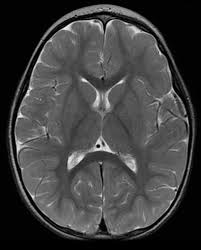

In [4]:
#get all images in rose file 
roses = list(data_dir.glob('no_tumor/*'))
# show third image 
PIL.Image.open(str(roses[146]))

loading all the files in tulips subdir

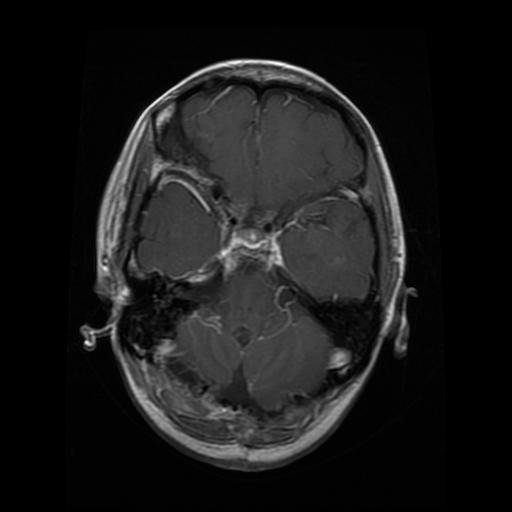

In [5]:
#get all images in tulips file
tulips = list(data_dir.glob('glioma_tumor/*'))
PIL.Image.open(str(tulips[3]))

We will use tf.keras.utils.image_dataset_from_directory this utils for loading datset from directory. As you know, we have just downloaded the dataset to its own directory.

define some parameters for image loader module

In [6]:
# Batch size
batch_size = 64
# image height
img_height = 180
# image width
img_width = 180

Use 80% of the images for training and 20% for validation.

We will create two separate sets for Train and Validation.

for train

In [7]:
# split dataset for train
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 10287 files belonging to 4 classes.
Using 8230 files for training.


for validation:

In [8]:
# split dataset for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 10287 files belonging to 4 classes.
Using 2057 files for validation.


finding class names is easy:

In [9]:
#get class names
class_names = train_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


we can now visualize some random images in each of the subdirs

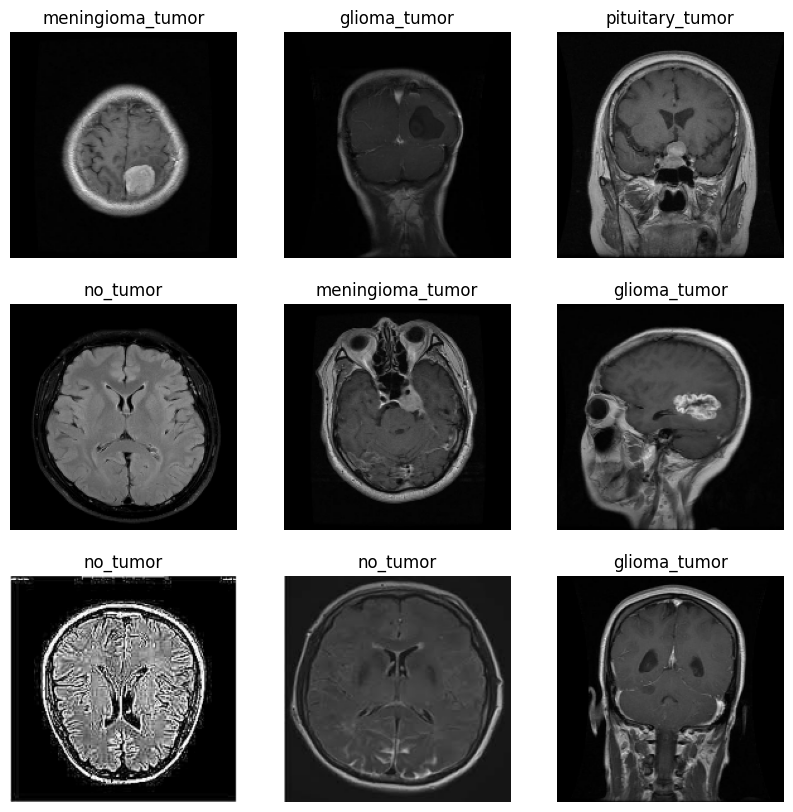

In [10]:
# determine figure size as 10 by 10
plt.figure(figsize=(10, 10))
# take image from train_ds
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plot image using imshow
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

now check the images shapes

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


this part is important, now there are two different ways to ensure all images are buffered before model training; so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

    Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
    
    Dataset.prefetch overlaps data preprocessing and model execution while training.

In [12]:
#Create autotune object
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the image

RGB channel values are in the range of [0, 255]. This is not ideal for a neural network and can be tiring, in general you should try to make your input values quite small so that it is easy to handle for a neural network.
based on this we will standardize the values to be in the range [0, 1] using tf.keras.layers:

In [13]:
# Create a normalization layer
normalization_layer = layers.Rescaling(1./255)

#normalize dataser using with norm. layer
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# sparete as image and label
image_batch, labels_batch = next(iter(normalized_ds))
# check the first image max and min value
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print("minumum value:",np.min(first_image), "maximum values: ",np.max(first_image))


minumum value: 0.0 maximum values:  1.0


Create a Model:

Now the model will actually consist of a simple CNN model to build.


The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [14]:
# get class names
num_classes = len(class_names)

# build model layers
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model

For this tutorial, we will use tf.keras.optimizers.Adam as optimizer and tf.keras.losses.SparseCategoricalCrossentropy for loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [15]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Check the model summary

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

input shape of the model is 180x180 and 3 channel. Total prameters of model is 3,989,285

Okey, now we can train the model

Train the model for 10 epochs with the Keras Model.fit method:

In [17]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


129/129 [==============================] - 34s 259ms/step - loss: 0.6863 - accuracy: 0.7179 - val_loss: 0.4350 - val_accuracy: 0.8488
Epoch 2/15
129/129 [==============================] - 33s 258ms/step - loss: 0.3171 - accuracy: 0.8818 - val_loss: 0.3107 - val_accuracy: 0.8916
Epoch 3/15
129/129 [==============================] - 33s 258ms/step - loss: 0.1763 - accuracy: 0.9372 - val_loss: 0.2294 - val_accuracy: 0.9276
Epoch 4/15
129/129 [==============================] - 33s 257ms/step - loss: 0.0979 - accuracy: 0.9659 - val_loss: 0.2130 - val_accuracy: 0.9315
Epoch 5/15
129/129 [==============================] - 28s 218ms/step - loss: 0.0604 - accuracy: 0.9796 - val_loss: 0.1823 - val_accuracy: 0.9572
Epoch 6/15
129/129 [==============================] - 26s 198ms/step - loss: 0.0312 - accuracy: 0.9905 - val_loss: 0.2070 - val_accuracy: 0.9567
Epoch 7/15
129/129 [==============================] - 25s 196ms/step - loss: 0.0251 - accuracy: 0.9922 - val_loss: 0.1643 - val_accuracy: 0.9

Now visualize the result of the model

Create plots of the loss and accuracy on the training and validation sets:

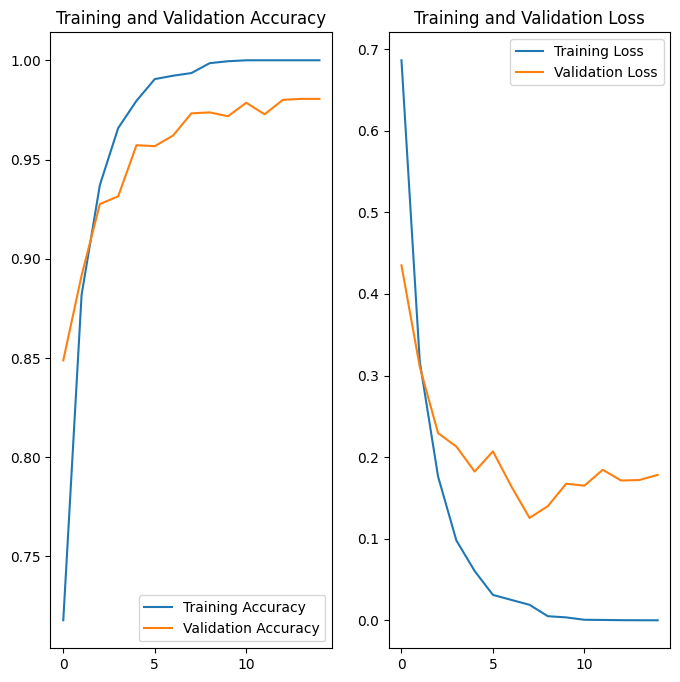

In [19]:
#get train accuracy in history
acc = history.history['accuracy']
#get validation accuracy
val_acc = history.history['val_accuracy']
# get train loss 
loss = history.history['loss']
#get validation loss
val_loss = history.history['val_loss']

epochs_range = range(epochs)
# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

While the training accuracy is around 91%, the validation rate is around 51%.

Here we should understand that; Building the model and dealing with data only does not give us the best model.

Let’s increase the model accuracy

How ?
Data Augmentation

Data augmentation can be called a technique of artificially augmenting the training set by creating modified copies of a data set using existing data. It involves making minor changes to the dataset or using deep learning to generate new data points. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [21]:
# create augmentation sequentions
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

let’s check the augmented sequentions, how it produce new image

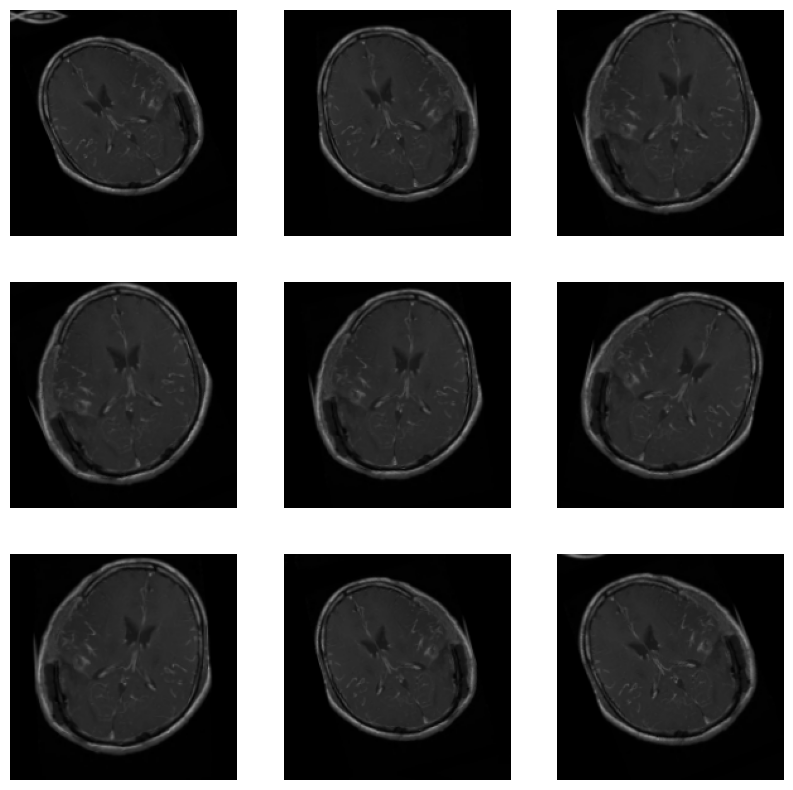

In [22]:
plt.figure(figsize=(10, 10))
#take second image in train dataset
for images, _ in train_ds.take(2):
  for i in range(9):
    #implement augmentation
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

As you can see, new pictures were created by processing the picture in the order we determined.

Now, Acquaintance Dropout

It was first introduced in 2014 in an article called Dropout: A Simple Way to Prevent Neural Networks from Overfitting. In summary, it is the technique of removing certain nodes from the hidden or input layer according to a certain rule (using a threshold value or randomly). For example, as can be seen in the figure below, when dropout is applied in a network model where the threshold value (treshold) is set to 0.5, the number of nodes in the hidden layer where dropout is applied is halved in the next layer.
link

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [23]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

Again Compile and train the model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [25]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
176/176 [==============================] - 25s 139ms/step - loss: 0.8074 - accuracy: 0.6559 - val_loss: 0.9255 - val_accuracy: 0.6643
Epoch 2/10
176/176 [==============================] - 25s 140ms/step - loss: 0.5809 - accuracy: 0.7588 - val_loss: 0.6450 - val_accuracy: 0.7562
Epoch 3/10
176/176 [==============================] - 25s 140ms/step - loss: 0.5101 - accuracy: 0.7982 - val_loss: 0.5574 - val_accuracy: 0.7840
Epoch 4/10
176/176 [==============================] - 25s 141ms/step - loss: 0.4479 - accuracy: 0.8167 - val_loss: 0.6089 - val_accuracy: 0.7712
Epoch 5/10
176/176 [==============================] - 25s 140ms/step - loss: 0.4164 - accuracy: 0.8311 - val_loss: 0.4101 - val_accuracy: 0.8375
Epoch 6/10
176/176 [==============================] - 24s 139ms/step - loss: 0.3818 - accuracy: 0.8454 - val_loss: 0.4775 - val_accuracy: 0.8147
Epoch 7/10
176/176 [==============================] - 24s 139ms/step - loss: 0.3737 - accuracy: 0.8539 - val_loss: 0.5272 - val_ac

Now the result with augmented photos

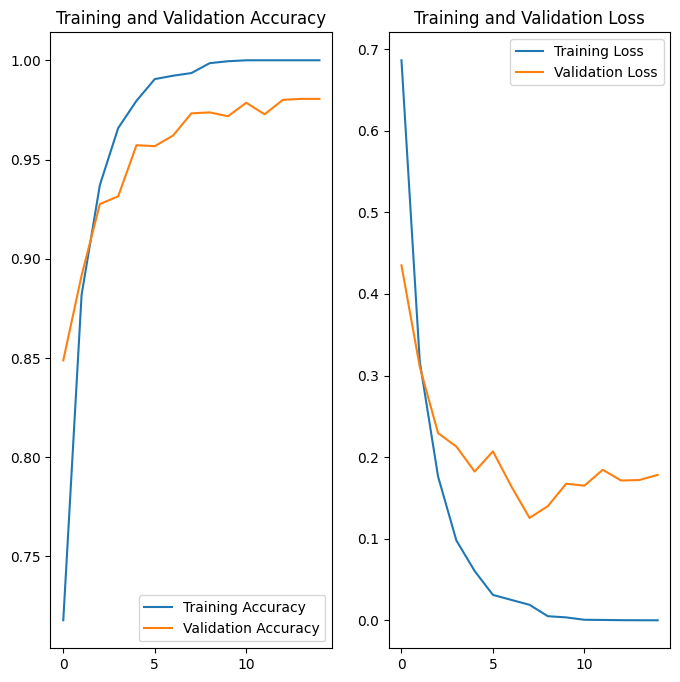

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After using the data augmentation and Dropout methods, our model has a more acceptable success rate. Methods like these help improve your model.

Let’s get to the important part; Let’s look at the prediction of the model we developed and test it.

In [27]:
#image url
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#dowload image
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
#load image
img = tf.keras.utils.load_img(
    'testnotumor.png', target_size=(img_height, img_width)
)
# image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

#make prediction
predictions = model.predict(img_array)
#get score
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 14ms/step
This image most likely belongs to no_tumor with a 99.97 percent confidence.


As you can see it is that simple and easy.
We developed a model in a very short time, then applied methods to improve it, and finally, we tested the model by making the model’s predictions.

saving the model

In [28]:
model.save('brain_tumor_classification.keras')


In [29]:
score

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([2.7043483e-04, 5.4355132e-05, 9.9965918e-01, 1.6053531e-05],
      dtype=float32)>